# IAS 150 Graphing

### Imports

https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e

In [2]:
%matplotlib inline
from IPython.display import display
import pandas as pd
import numpy as np
import migrant_functions as mf
import qgrid as qg
import matplotlib.pyplot as plt
import matplotlib as mtplt
import jordan as j
import random
from matplotlib import gridspec
import folium as fl
print (fl.__version__)
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')

0.2.1



        (1) finish extract_top_5
        (2) create centroid dataset
        (3) debug
        (4) code bar graph

In [3]:
migrant_data = pd.read_csv('migrant_table_final_appended.csv')

In [416]:
def convert(migraiton_type):
    if migraiton_type == 1:
        return 'Immigration'
    else:
        return 'Emigration'
        

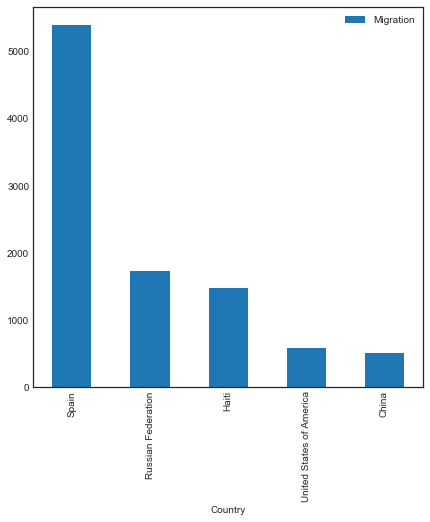

In [57]:
needed = migrant_data.loc[(migrant_data['Gender'] == 'female') &
                              (migrant_data['Country'] == 'Cuba') &
                              (migrant_data['Year'] == 1990) &
                              (migrant_data['Migration Type'] == convert(1)),:][['Country 1', 'Country 1 Count',
                     'Country 2', 'Country 2 Count',
                     'Country 3', 'Country 3 Count',
                     'Country 4', 'Country 4 Count',
                     'Country 5', 'Country 5 Count']]

needed = needed.apply(lambda x: x.tolist(), axis=1).values[0]

country_list = needed[0::2]
migration_list = needed[1::2]

pd.DataFrame({'Country': country_list, 'Migration': migration_list}).set_index('Country').plot(kind='bar');

In [99]:
def extract_top_5(migrant_data, country, gender, year, migration_type, log=False):
    
    english_mtype = convert(migration_type)

    
    needed = migrant_data.loc[(migrant_data['Gender'] == gender) &
                              (migrant_data['Country'] == country) &
                              (migrant_data['Year'] == year) &
                              (migrant_data['Migration Type'] == english_mtype),:]
    
    
    needed = migrant_data[['Country 1', 'Country 1 Count',
                     'Country 2', 'Country 2 Count',
                     'Country 3', 'Country 3 Count',
                     'Country 4', 'Country 4 Count',
                     'Country 5', 'Country 5 Count']]
    
    
    needed = needed.apply(lambda x: x.tolist(), axis=1).values[0]

    country_list = needed[0::2]
    
    if log:
        migration_list = np.log(needed[1::2])
    elif not log:
        migration_list = needed[1::2]
        
    bar_graph_table = pd.DataFrame({'Country': country_list, 'Migration': migration_list}).set_index('Country')

    centroid_list = []
    for country in country_list:
        centroid = tuple(list(centroids.loc[centroids['Name']==country,['Lat', 'Long']].iloc[0].values))
        centroid_list.append(centroid)
        
    country_dict = {}
    rank = 1
    for i in range(len(country_list)):
        country_dict[country_list[i]] = [migration_list[i], centroid_list[i][0], centroid_list[i][1], rank]
        rank += 1 
    
    return [country_dict, bar_graph_table]
        
    
    

In [102]:
extract_top_5(migrant_data, 'Cuba', 'female', 2000, 'Immigration')[0]

{'Dominican Republic': [3900, 18.735693, -70.162651, 5],
 'Puerto Rico': [9510, 18.220833, -66.590149, 2],
 'Spain': [9264, 40.463667, -3.74922, 3],
 'United States of America': [351002, 37.09024, -95.712891, 1],
 'Venezuela (Bolivarian Republic of)': [5874, 6.42375, -66.58973, 4]}

In [403]:
def get_arrows(the_map, locations, color, size=6, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2)
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(fl.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=rotation).add_to(the_map))
    return arrows

def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing


In [404]:
type(extract_top_5(migrant_data, 'Cuba', 'female', 2000, 1)[0])

dict

In [409]:
def map_it(migrant_data, country, gender, year, migration_type):
    
    
    country_location = list(centroids.loc[centroids['Name']==country,['Lat', 'Long']].iloc[0].values)
    
    country_dict = extract_top_5(migrant_data, country, gender, year, migration_type)[0]

    the_map = fl.Map(location=[20,0], tiles="Mapbox Bright", zoom_start=2)
    
    if migration_type == 2:
        
        
        the_map.circle_marker(
          location= country_location,
          popup = [country],
          radius = 150000,
          fill_color='gold')
        
        
        for country in country_dict.keys():
        
            the_map.circle_marker(
              location= [country_dict[country][1], country_dict[country][2]],
              popup =country+ ", " + "Rank: " + str(country_dict[country][3]) + ', ' + convert(migration_type) + ' Total: ' + str(country_dict[country][0]),
              radius = 100000,
              fill_color='blue')
        
        for country in country_dict:  
            location = [country_dict[country][1], country_dict[country][2]]       
            line = fl.PolyLine(locations=[country_location,location], color='blue', weight=7)
            the_map.add_children(line)
#             get_arrows(the_map, locations=[country_location,location], color = 'blue', n_arrows=3)
    
    if migration_type == 1:
                
        the_map.circle_marker(
          location= country_location,
          popup = [country],
          radius = 150000,
          fill_color='blue')

        for country in country_dict.keys():

            the_map.circle_marker(
              location= [country_dict[country][1], country_dict[country][2]],
              popup = country+ ", " + "Rank: " + str(country_dict[country][3]) + ', ' + convert(migration_type) + ' Total: ' + str(country_dict[country][0]),
              radius = 100000,
              fill_color='gold')
        
        
        
        for country in country_dict:
            location = [country_dict[country][1], country_dict[country][2]]    
            line = fl.PolyLine(locations=[location,country_location], color='gold', weight=7)
            the_map.add_children(line)
#             get_arrows(the_map, locations=[location,country_location], color='gold', n_arrows=3)       
    
    display(the_map)

In [410]:
def graph_it(migrant_data, country, gender, year, migration_type, axis, log=False):
    return extract_top_5(migrant_data, country, gender, year, migration_type, log=log)[1].plot(kind='bar',ax=axis)

In [411]:
def map_and_graph(migrant_data, country, gender, year, migration_type):
    
    fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,15));

    g1 = graph_it(migrant_data, country, gender, year, migration_type, axes[0], log=False)
    g2 = graph_it(migrant_data, country, gender, year, migration_type, axes[1], log=True)
    map_it(migrant_data, country, gender, year, migration_type)
    
    axes[0].set_title("Top 5 " + convert(migration_type) + " Normal Scale", size=20)
    axes[1].set_title("Top 5 " + convert(migration_type) + " Logarithmic Scale", size=20)
    
    axes[0].set_ylabel('Counts', size=22)
    axes[0].set_xlabel('Country', size=22)
    axes[1].set_xlabel('Country', size=22)
    axes[1].set_ylabel('Counts', size=22)
    
    for tick in g1.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
        
    for tick in g1.yaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
        
        
    for tick in g2.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
                
    for tick in g2.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    

    plt.suptitle('Top 5 Countries, Bar Graphs', size=25)
    plt.show()


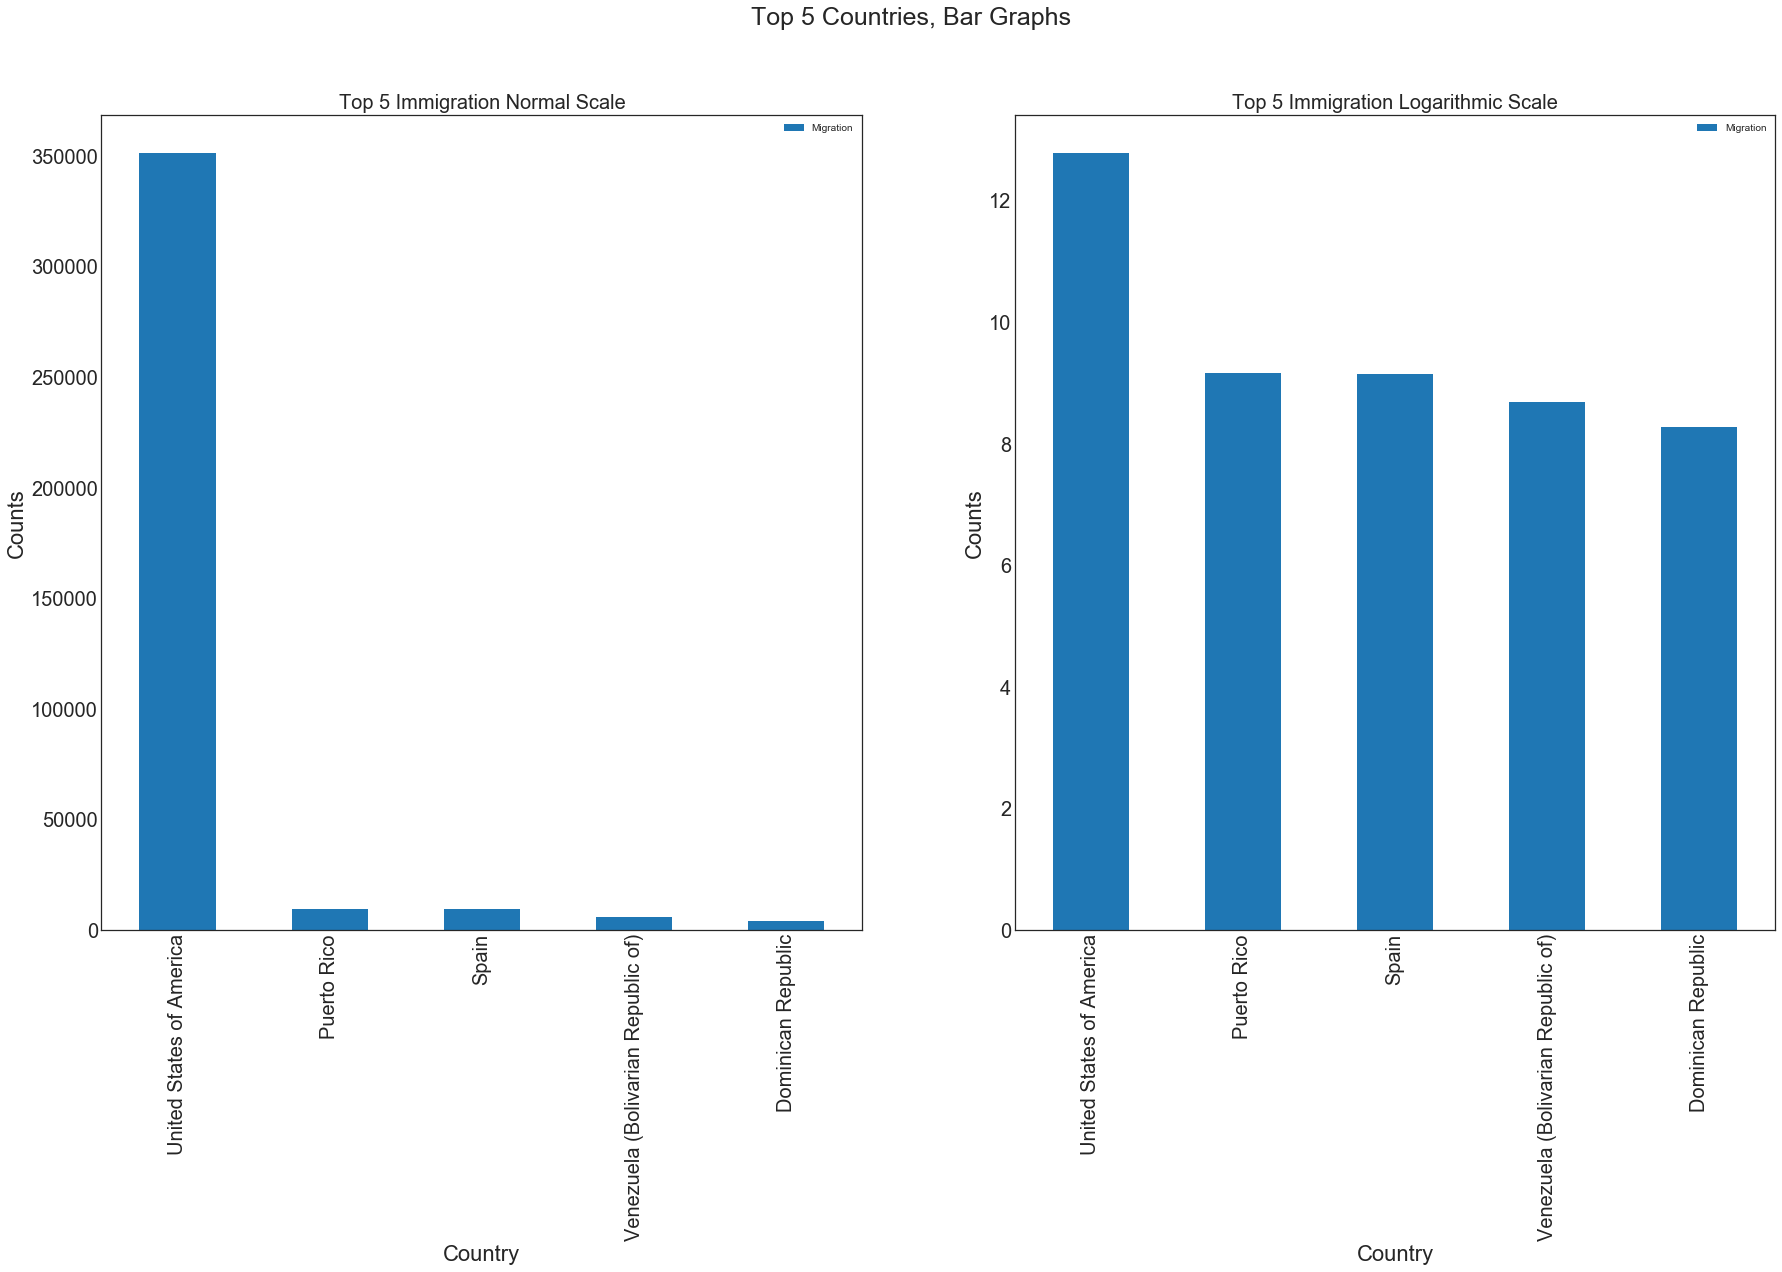

In [413]:
map_and_graph(migrant_data, 'China', 'total', 2000, 1)

In [420]:
# Compares Multiple Countries
# Arguments:
    # variable: Gender
    # variable_type: Male or Female
    # immigraiton_type: type of migration (Immigration or Emigration)
        # this is to be specified when looking at gender as the variable
    # interest_country_list: countries to compare
    # plot_type: 'line' or 'bar'

# either a bar graph or line graph
    # if bar, x = year, y=variable
    # if line, y=country, x=year

def multiple_pick_and_graph(migrant_data, gender, immigration_type, interest_country_list, plot_type):
    
    conversion = {1:'Immigration', 2:'Emigration'}
    
    immigration_typey =  conversion[immigration_type]
    
    
    
    selected_data = migrant_data.loc[(migrant_data['Gender'] == gender)
                                     & (migrant_data['Migration Type'] == immigration_typey),:]
    
    picks = selected_data[['Country', 'Year', 'Total Migration']]
    
    if plot_type == 'line':
        
        if len(interest_country_list) > 2:
            print('Line plot only support one or two countries!')
            return None
        
        plt.figure(figsize=(10,10))
    
        plt.style.use('seaborn-white')
#         my_dpi=96
#         plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)


        # multiple line plot
        country_list = list(np.unique(picks['Country']))
        end_values = []
        
        if len(interest_country_list)==2:
       
            for country in country_list:

                country_picks = picks.loc[picks['Country'] == country,:]

                if country == interest_country_list[0]:
                    end_value_0 = picks.loc[picks['Country'] == country,:].values[6][2]
                    plt.plot(country_picks['Year'].values, np.log(country_picks['Total Migration'].values), marker='', color='blue', linewidth=5, alpha=0.7)

                elif country == interest_country_list[1]:
                    end_value_1 = picks.loc[picks['Country'] == country,:].values[6][2]
                    plt.plot(country_picks['Year'].values, np.log(country_picks['Total Migration'].values), marker='', color='red', linewidth=5, alpha=0.7)

                else:
                    plt.plot(country_picks['Year'].values, np.log(country_picks['Total Migration'].values), marker='', color='black', linewidth=1, alpha=0.4)
        
        if len(interest_country_list)==1:
            
            for country in country_list:

                country_picks = picks.loc[picks['Country'] == country,:]

                if country == interest_country_list[0]:
                    end_value_0 = picks.loc[picks['Country'] == country,:].values[6][2]
                    plt.plot(country_picks['Year'].values, np.log(country_picks['Total Migration'].values), marker='', color='blue', linewidth=5, alpha=0.7)

                else:
                    plt.plot(country_picks['Year'].values, np.log(country_picks['Total Migration'].values), marker='', color='black', linewidth=1, alpha=0.4)


        plt.xlim(1989, 2018);
        plt.ylim(7, 20);

        def rand_jitter(arr):
            stdev = .01*(max(arr)-min(arr))
            return arr + np.random.randn(len(arr)) * stdev



        plt.text(2020, np.log(end_value_0), interest_country_list[0], horizontalalignment='left', size='large', color='black')
        if len(interest_country_list) == 2:
            plt.text(2019, np.log(end_value_1), interest_country_list[1], horizontalalignment='left', size='large', color='black')

        plt.title(gender + ' ' + 'immigration ' + "For Each Country, by Year", loc='left', fontsize=15, fontweight=0, color='black');
        plt.xlabel("Year", size=15);
        plt.ylabel("log(Immigration)", size=15);
        plt.show()
        
    
    elif plot_type == 'bar': 
        
        plt.figure(figsize=(10,10))
        
        # set width of bar
        barWidth = 0.25

        # set height of bar
        bars = []
        for country in interest_country_list:            
            picks1 = picks.loc[picks['Country'] == country,:]
            bars1 = list(picks1.loc[:,'Total Migration'].values)
            bars.append(bars1)
        
        
        # Set position of bar on X axis
        current = np.arange(len(bars[0]))
        positions = [current]
        for bar in bars[1:]:
            r = [x + barWidth for x in current]
            positions.append(r)
            current = r

        #Make the plot
        for pos, bar, label in zip(positions, bars, interest_country_list):
            plt.bar(pos, bar, color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)), width=barWidth, edgecolor='white', label=label)

        # Add xticks on the middle of the group bars
        plt.title('Side by Side Comprison of ' + immigration_typey + ' for Selected Countries, by Year', size=15)
        plt.xlabel('Year', fontweight='bold', size=15)
        plt.ylabel('Counts', fontweight='bold', size=15)
        plt.xticks([r + barWidth for r in range(len(bars[0]))], ['1990', '1995', '2000', 
                                                                 '2005', '2010', '2015', '2017'])


        # Create legend & Show graphic
        plt.legend(prop={'size': 15})
        plt.show()

    else:
        print('Not a valid visulization!')
        
        
    

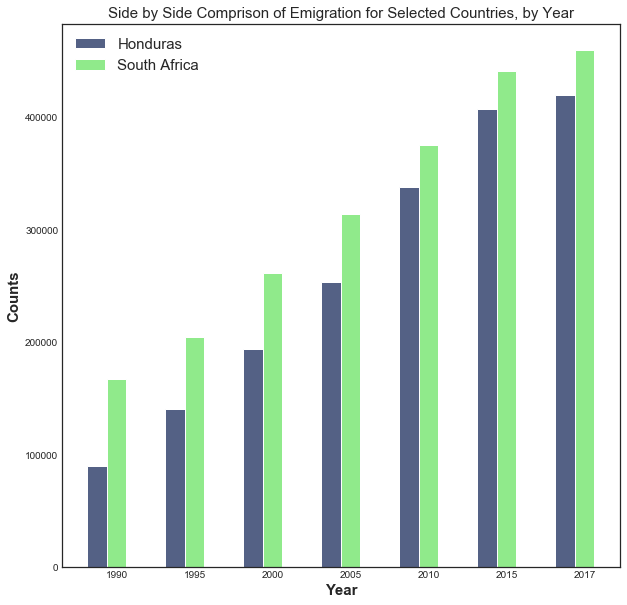

In [422]:
multiple_pick_and_graph(migrant_data, 'male', 2, ['Honduras', 'South Africa'], 'bar')

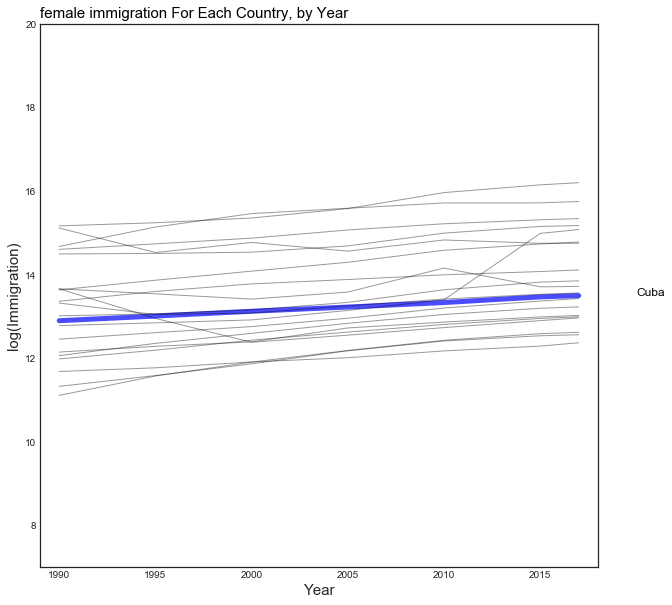

In [423]:
multiple_pick_and_graph(migrant_data, 'female', 2, ['Cuba'], 'line')

In [370]:
# Takes one country, and compares different aspects of it by gender (and possibly by year)
# Arguemnts:
    # country: Country of Interest
    # aspect: Numerical [1, 2, 3]
# Optional Argument(s):
    # Year (Defaults to False): If True, displays a cluster of bar graphs for each year
# Possible Aspects Key:
    # Aspect 1: Immgration
    # Aspect 2: Emigration
    # Aspect 3: Age Ranges (Immigration Only)



def one_pick_and_graph(country, aspect, year=False):
    
    conversion = {1:'Immigration', 2:'Emigration', 3:'Age Ranges (Immigration)'}
    
    
    if aspect not in [1, 2, 3]:
        print('Not a valid aspect to compare!')
        return
    
    if aspect == 1:
        selected_data = migrant_data.loc[(migrant_data['Country'] == country)
                                     & (migrant_data['Migration Type'] == 'Immigration'),:]
        
        if year:
            picks = selected_data[['Year', 'Gender', 'Total Migration']]
        else:
            picks = selected_data[['Gender', 'Total Migration']].groupby('Gender').agg(sum)
            
    elif aspect == 2:
        selected_data = migrant_data.loc[(migrant_data['Country'] == country)
                                     & (migrant_data['Migration Type'] == 'Emigration'),:]
        
        if year:
            picks = selected_data[['Year', 'Gender', 'Total Migration']]
        else:
            picks = selected_data[['Gender', 'Total Migration']].groupby('Gender').agg(sum)
        
    elif aspect == 3:
        selected_data = migrant_data.loc[(migrant_data['Country'] == country)
                                     & (migrant_data['Migration Type'] == 'Immigration'),:]
        if year:
            picks = selected_data[['Year', 'Gender', 'Migrants Under 15 years old',
                                   'Migrants 20-29 years old',
                                   'Migrants 30-39 years old',
                                   'Migrants 40-49 years old',
                                   'Migrants 50 years old and older']]
        else:
            picks = selected_data[['Gender', 'Migrants Under 15 years old',
                                   'Migrants 20-29 years old',
                                   'Migrants 30-39 years old',
                                   'Migrants 40-49 years old',
                                   'Migrants 50 years old and older']].groupby('Gender').agg(sum)
                                     
    
    if not year:
        plotty = picks.plot(kind='bar', figsize=(7,7));
        plt.xlabel('Gender', size=15)
        plt.ylabel('Counts', size=15)
        plt.title(conversion[aspect] + ' Counts', size=15)
    else:
        if aspect != 3:
            
            barWidth = 0.25

            # set height of bar
            bars = []
            for gender in ['female', 'male', 'total']:            
                picks1 = picks.loc[picks['Gender'] == gender,:]
                bars1 = list(picks1.loc[:,'Total Migration'].values)
                bars.append(bars1)


            # Set position of bar on X axis
            current = np.arange(len(bars[0]))
            positions = [current]
            for bar in bars[1:]:
                r = [x + barWidth for x in current]
                positions.append(r)
                current = r

            #Make the plot
            for pos, bar, label in zip(positions, bars, ['female', 'male', 'total']):
                plt.bar(pos, bar, color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)), width=barWidth, edgecolor='white', label=label)
                
            # Add xticks on the middle of the group bars
            plt.xlabel('Year', size=15)
            plt.xlabel('Counts', size=15)
            plt.title(conversion[aspect] + ' Counts by Year', size=15)
            plt.xticks([r + barWidth for r in range(len(bars[0]))], ['1990', '1995', '2000', 
                                                                     '2005', '2010', '2015', '2017'])
            plt.xlabel('Gender', size=15)
            plt.ylabel('Counts', size=15)
            fig_size = plt.rcParams["figure.figsize"]
            fig_size[0] = 7
            fig_size[1] = 7
            plt.legend()
        
        # CREATE SUBPLOTS
        else:
            
            fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,15));
            
            axes[0].set_title("Age Range Immigration by Year, Male", size=20)
            axes[0].set_ylabel('Counts', size=22)
            axes[0].set_xlabel('Year', size=22)
            axes[1].set_xlabel('Year', size=22)
            axes[1].set_title("Age Range Immigration by Year, Female", size=20)
            
            
            plt.legend(prop={'size': 6})
            
            
            for tick in axes[0].xaxis.get_major_ticks():
                tick.label.set_fontsize(22) 
                
            for tick in axes[1].xaxis.get_major_ticks():
                tick.label.set_fontsize(22)
                
            for tick in axes[0].yaxis.get_major_ticks():
                tick.label.set_fontsize(22) 
                
            for tick in axes[1].yaxis.get_major_ticks():
                tick.label.set_fontsize(22)
                
            
            male = picks.loc[picks['Gender'] == 'male'].drop(columns='Gender')
            m = male.plot(x='Year', kind='line', ax=axes[0]);
            m.legend(prop={'size': 15})
            
            female = picks.loc[picks['Gender'] == 'female'].drop(columns='Gender')
            f = female.plot(x='Year', kind='line', ax=axes[1]);
            f.legend(prop={'size': 15})
            
            total = picks.loc[picks['Gender'] == 'total'].drop(columns='Gender')
            t = total.plot(x='Year', kind='line', figsize=(25,15));
            t.legend(prop={'size': 15})
            t.set_ylabel('Counts', size=22)
            t.set_xlabel('Year', size=22)
            t.set_title("Age Range Immigration by Year, Total", size=22)
            
            for tick in t.xaxis.get_major_ticks():
                tick.label.set_fontsize(22) 
                
            for tick in t.yaxis.get_major_ticks():
                tick.label.set_fontsize(22)
            
        


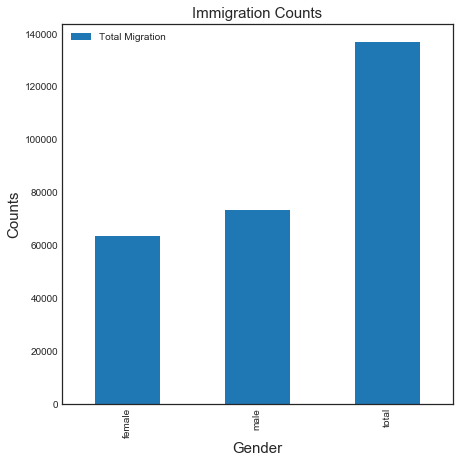

In [371]:
one_pick_and_graph('Cuba', 1, year=False)

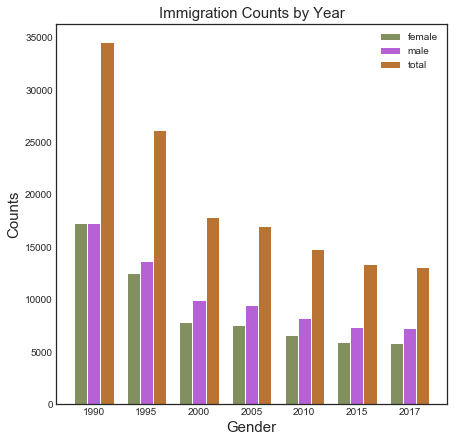

In [372]:
one_pick_and_graph('Cuba', 1, year=True)

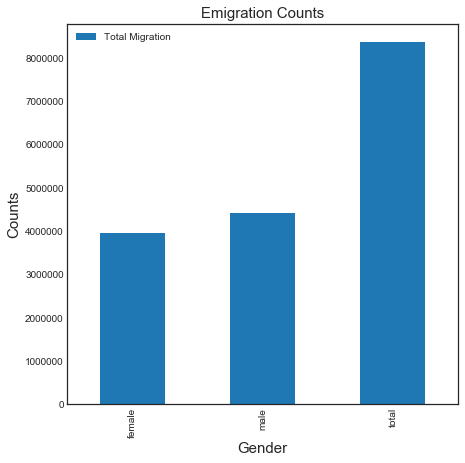

In [373]:
one_pick_and_graph('Cuba', 2, year=False)

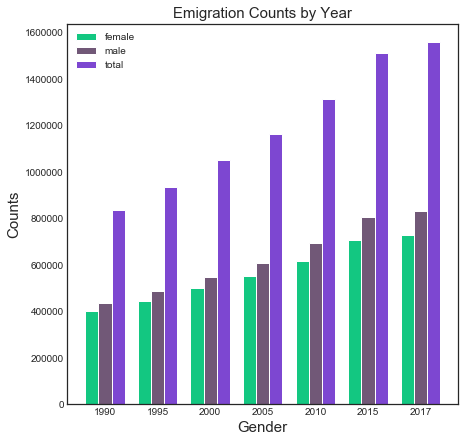

In [374]:
one_pick_and_graph('Cuba', 2, year=True)

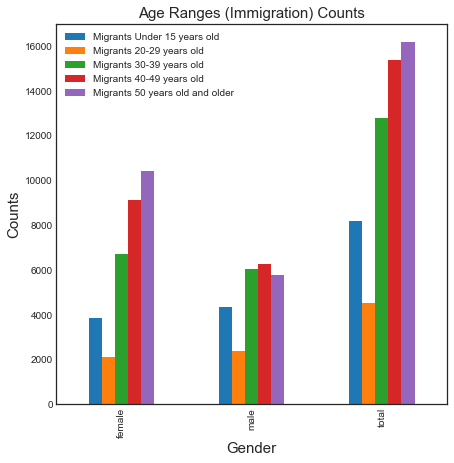

In [375]:
one_pick_and_graph('Cuba', 3, year=False)

No handles with labels found to put in legend.


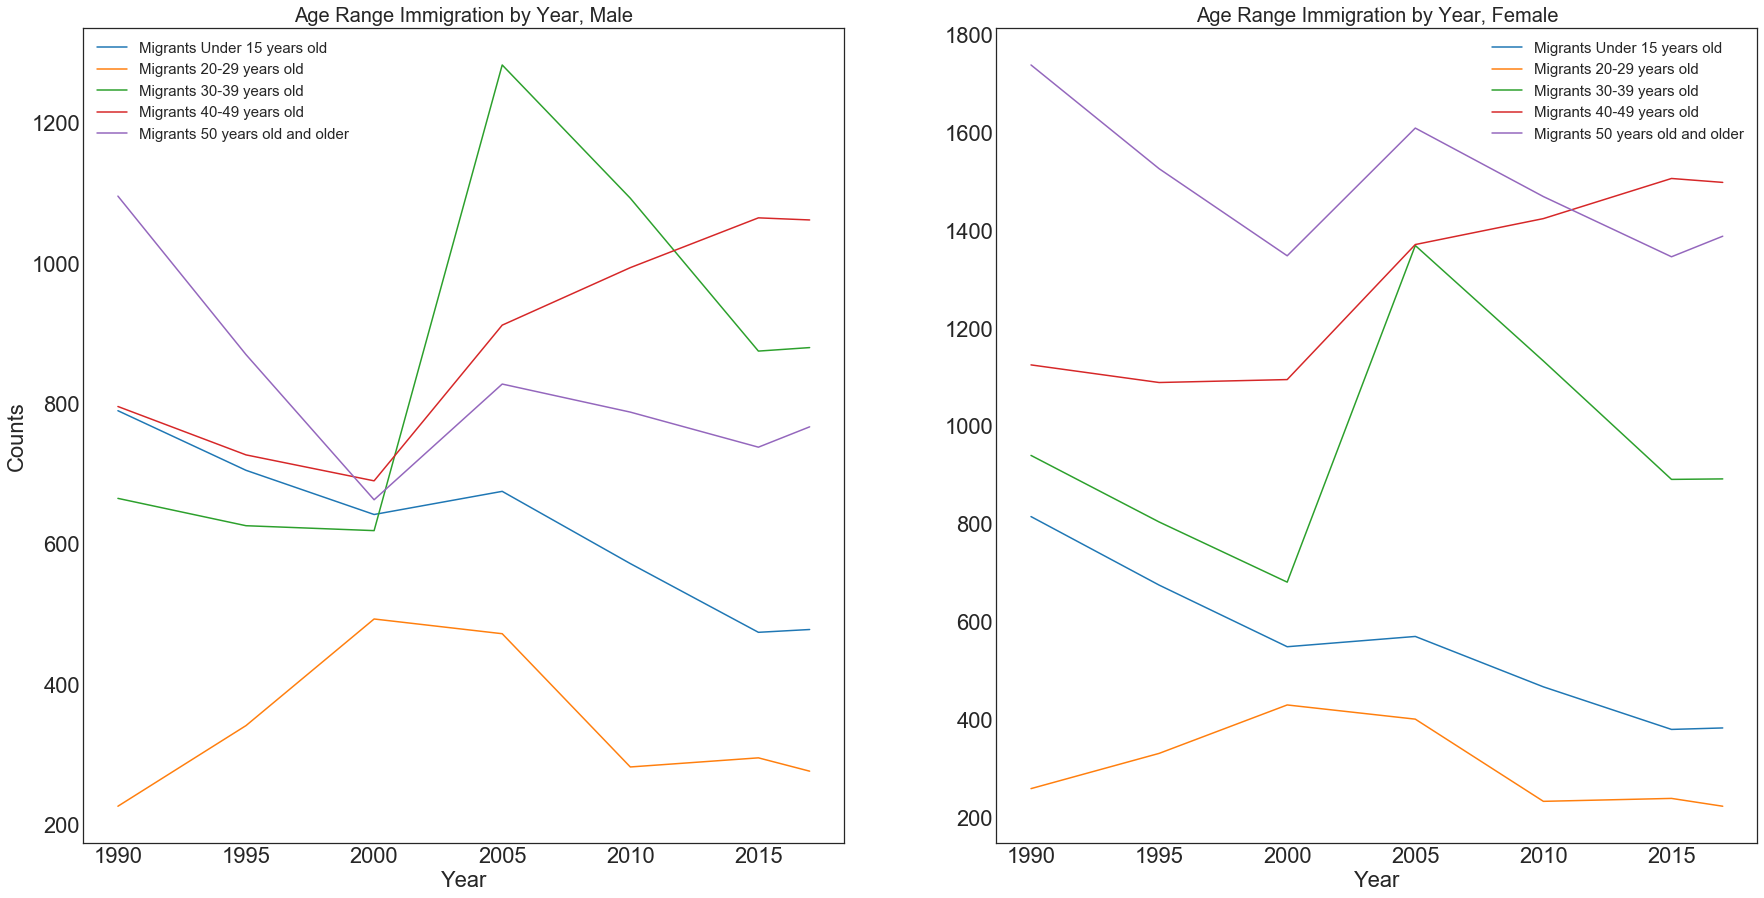

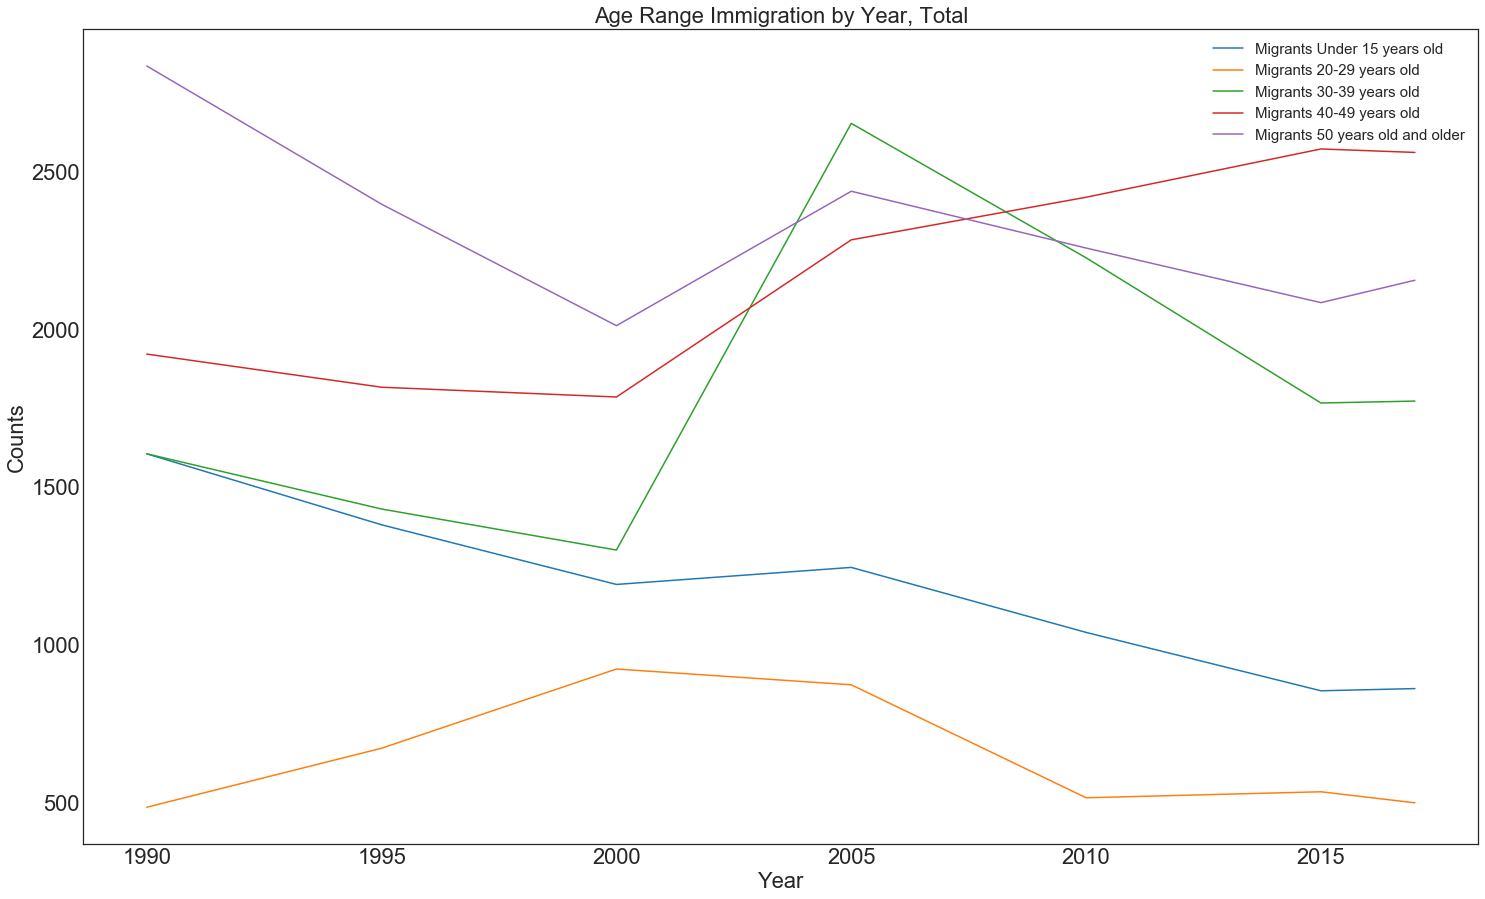

In [376]:
one_pick_and_graph('Cuba', 3, year=True)

In [377]:
def migration_side_by_side(country):
    
    selected_data = migrant_data.loc[(migrant_data['Country'] == country),:][['Year', 'Gender', 'Migration Type', 'Total Migration']]
        
    
    gender_tables = {}
    
    for gender in ['total', 'male', 'female']:
        
        emigration = selected_data.loc[(selected_data['Gender'] == gender) & (selected_data['Migration Type'] == 'Emigration'),:].drop(columns='Gender')['Total Migration'].values
        immigration = selected_data.loc[(selected_data['Gender'] == gender) & (selected_data['Migration Type'] == 'Immigration'),:].drop(columns='Gender')['Total Migration'].values
        year = selected_data.loc[(selected_data['Gender'] == gender) & (selected_data['Migration Type'] == 'Immigration'),:].drop(columns='Gender')['Year'].values
        
        gender_tables[gender] = pd.DataFrame(data={"Year": year,'Immigration': immigration, 'Emigration': emigration})

    fig1, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,15));
    
    axes.set_title("Total Emigration vs Immigration, by Year", size=30)

    axes.set_ylabel('Counts', size=30)

    axes.set_xlabel('Year', size=30)

    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(30) 

    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(30) 

    total = gender_tables['total']
    t_plot = total.plot(x='Year', kind='bar', ax=axes);
    t_plot.legend(prop={'size': 30})
        

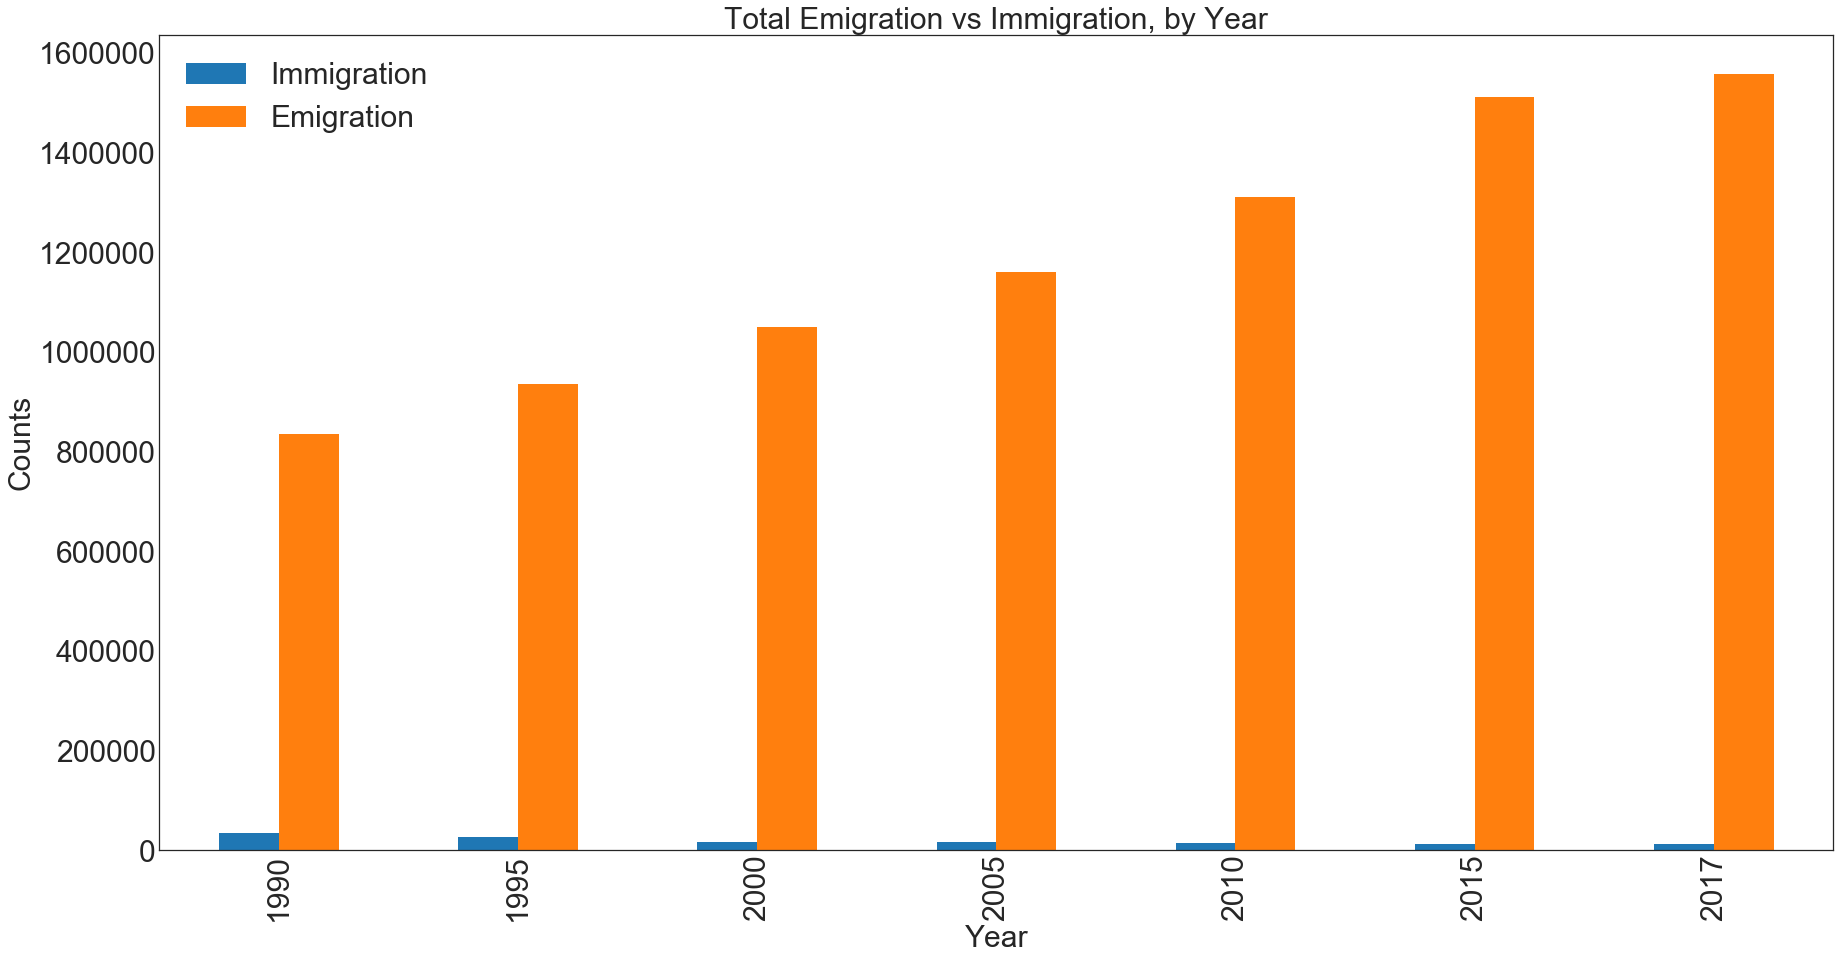

In [378]:
migration_side_by_side('Cuba')

In [6]:
migrant_data = migrant_data.head().rename(index=str, columns={"Year.1": "Year"})

,Year,Code,Country,Year,Migration Type,Total Migration,Gender,Country 1,Country 1 Count,Country 2,...,War or Genocide?,Government instability?,Organized crime?,Economic recession?,Financial crisis?,GDP,Natural disasters?,Man-made disasters?,Passport power rating,Changes over-time in access to visas?
0,1990,4,Afghanistan,1990,Emigration,3661547,female,Iran (Islamic Republic of),1788296,Pakistan,...,Yes,Yes,Yes,Yes,Yes,3622,Yes,Yes,92,Yes
1,1990,4,Afghanistan,1990,Emigration,3063134,male,Pakistan,1603573,Iran (Islamic Republic of),...,Yes,Yes,Yes,Yes,Yes,3622,Yes,Yes,92,Yes
2,1990,4,Afghanistan,1990,Emigration,6724681,total,Pakistan,3276673,Iran (Islamic Republic of),...,Yes,Yes,Yes,Yes,Yes,3622,Yes,Yes,92,Yes
3,1990,4,Afghanistan,1990,Immigration,32558,female,Tajikistan,22879,Pakistan,...,Yes,Yes,Yes,Yes,Yes,3622,Yes,Yes,92,Yes
4,1990,4,Afghanistan,1990,Immigration,25128,male,Tajikistan,17658,Pakistan,...,Yes,Yes,Yes,Yes,Yes,3622,Yes,Yes,92,Yes


In [67]:
def gdp(migrant_data, country1, country2):
    
    c1 = migrant_data.loc[(migrant_data['Country']=='Cuba')&(migrant_data['Gender']=='male')&
                                (migrant_data['Migration Type']=='Immigration'),:][['Year', 'GDP ']].rename(columns={'GDP ':country1})

    c2 = migrant_data.loc[(migrant_data['Country']=='Honduras')&(migrant_data['Gender']=='male')&
                                (migrant_data['Migration Type']=='Immigration'),:][['Year', 'GDP ']].rename(columns={'GDP ':country2})

    pd.merge(c1, c2, on='Year').plot(x='Year', figsize=(15,8));
    plt.xlabel('Year', size=15)
    plt.ylabel('GDP (Millions)', size=15)
    plt.title('GDP by Year', size=15)
    

    
    

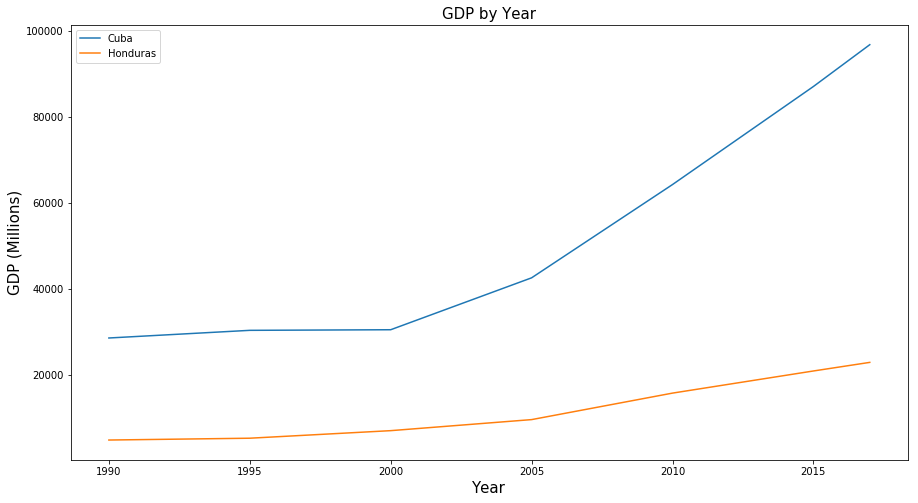

In [68]:
gdp(migrant_data, 'Cuba', 'Honduras')